# Datasets

Following the method described by Chen et al. (2025), we use contrasting prompts to extract steering vectors that capture specific traits. In this notebook we prepare datasets of text pairs exhibiting contrasting complexity levels.

---
**Reference:**
Chen, R., Arditi, A., Sleight, H., Evans, O., & Lindsey,
J. (2025). Persona Vectors: Monitoring and Controlling
Character Traits in Language Models. *arXiv preprint
arXiv:2507.21509*. https://arxiv.org/abs/2507.21509

## Complexity: OneStopEnglish

[OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification](https://aclanthology.org/W18-0535/) (Vajjala & Lučić, BEA 2018)

The OneStopEnglish corpus includes 189 texts written to three target reading levels: elementary, intermediate and advanced. We selected the elementary and advanced texts, and computed Flesch-Kincaid reading levels for each text in each pair. Pairs where the delta (advanced - elementary) was less than 4.0 grade levels were excluded. We sorted the qualifying pairs by grade-level delta and selected the top 20 for inclusion in the dataset.

In [10]:
import os
import pandas as pd
import textstat
import json
from datasets import load_dataset

# Check if we already have the data
data_dir = '../data'
all_pairs_path = os.path.join(data_dir, 'onestop_all_pairs.csv')

if os.path.exists(all_pairs_path):
    print("✓ Found existing OneStopEnglish data, loading from disk...")
    df = pd.read_csv(all_pairs_path)
    print(f"✓ Loaded {len(df)} pairs from {all_pairs_path}")
else:
    print("No existing data found, fetching from HuggingFace...")

    # Load OneStopEnglish corpus from HuggingFace
    print("Loading OneStopEnglish dataset...")
    dataset = load_dataset("iastate/onestop_english")
    data = dataset['train']
    print(f"✓ Dataset loaded: {len(data)} items")

    # Dataset structure: 189 articles × 3 levels (0=elementary, 1=intermediate, 2=advanced)
    # Items are ordered: all level 0, then all level 1, then all level 2
    # So article i appears at indices [i, i+189, i+378]

    n_articles = 189
    pairs = []

    print(f"\nProcessing {n_articles} articles...")

    for i in range(n_articles):
        elem_text = data[i]['text']              # elementary (label 0)
        adv_text = data[i + 2*n_articles]['text'] # advanced (label 2)

        try:
            elem_gl = textstat.flesch_kincaid_grade(elem_text)
            adv_gl = textstat.flesch_kincaid_grade(adv_text)
            delta = adv_gl - elem_gl

            pairs.append({
                'article_id': i,
                'elementary_text': elem_text,
                'advanced_text': adv_text,
                'elementary_gl': elem_gl,
                'advanced_gl': adv_gl,
                'delta_gl': delta,
                'elementary_words': textstat.lexicon_count(elem_text, removepunct=True),
                'advanced_words': textstat.lexicon_count(adv_text, removepunct=True),
            })
        except Exception as e:
            print(f"Skipping article {i}: {e}")
            continue

    # Convert to DataFrame and sort by delta
    df = pd.DataFrame(pairs)
    df = df.sort_values('delta_gl', ascending=False).reset_index(drop=True)

    print(f"\n✓ Processed {len(df)} elementary-advanced pairs")
    print(f"\nGrade level delta statistics:")
    print(df['delta_gl'].describe())

    # Save to data/ directory
    os.makedirs(data_dir, exist_ok=True)

    # Save full dataset for reference
    df.to_csv(all_pairs_path, index=False)
    print(f"\n✓ Saved {len(df)} pairs to {all_pairs_path}")

# Always show summary statistics
print(f"\nGrade level delta statistics:")
print(df['delta_gl'].describe())

# Select top 20 pairs by grade-level spread
top_20 = df.head(20).copy()

print(f"\nTop 20 pairs by grade-level delta:")
print(top_20[['article_id', 'elementary_gl', 'advanced_gl', 'delta_gl', 'elementary_words', 'advanced_words']])

# Save top 20 for vector extraction
top_20_path = os.path.join(data_dir, 'onestop_top20_pairs.csv')
top_20.to_csv(top_20_path, index=False)
print(f"\n✓ Saved top 20 pairs to {top_20_path}")

# Save just the texts in a format easy to iterate over
top_20_texts = []
for _, row in top_20.iterrows():
    top_20_texts.append({
        'article_id': row['article_id'],
        'low_complexity': row['elementary_text'],
        'high_complexity': row['advanced_text'],
    })

top_20_texts_path = os.path.join(data_dir, 'onestop_top20_texts.json')
with open(top_20_texts_path, 'w') as f:
    json.dump(top_20_texts, f, indent=2)

print(f"✓ Saved texts to {top_20_texts_path}")
print(f"\nReady for vector extraction!")

✓ Found existing OneStopEnglish data, loading from disk...
✓ Loaded 189 pairs from ../data/onestop_all_pairs.csv

Grade level delta statistics:
count    189.000000
mean       2.864126
std        1.256634
min       -2.380610
25%        1.946565
50%        2.795170
75%        3.749145
max        6.583746
Name: delta_gl, dtype: float64

Top 20 pairs by grade-level delta:
    article_id  elementary_gl  advanced_gl  delta_gl  elementary_words  \
0          130       8.058324    14.642070  6.583746               367   
1           25       8.254656    14.571224  6.316568               655   
2           55       7.670724    13.656337  5.985614               608   
3          155       8.009239    13.965805  5.956566               572   
4          119       7.348686    13.138659  5.789973               580   
5          121       7.589514    13.369118  5.779605               371   
6          115       6.746705    12.045946  5.299240               634   
7          147       7.921692    13.0

### Dataset Quality Analysis

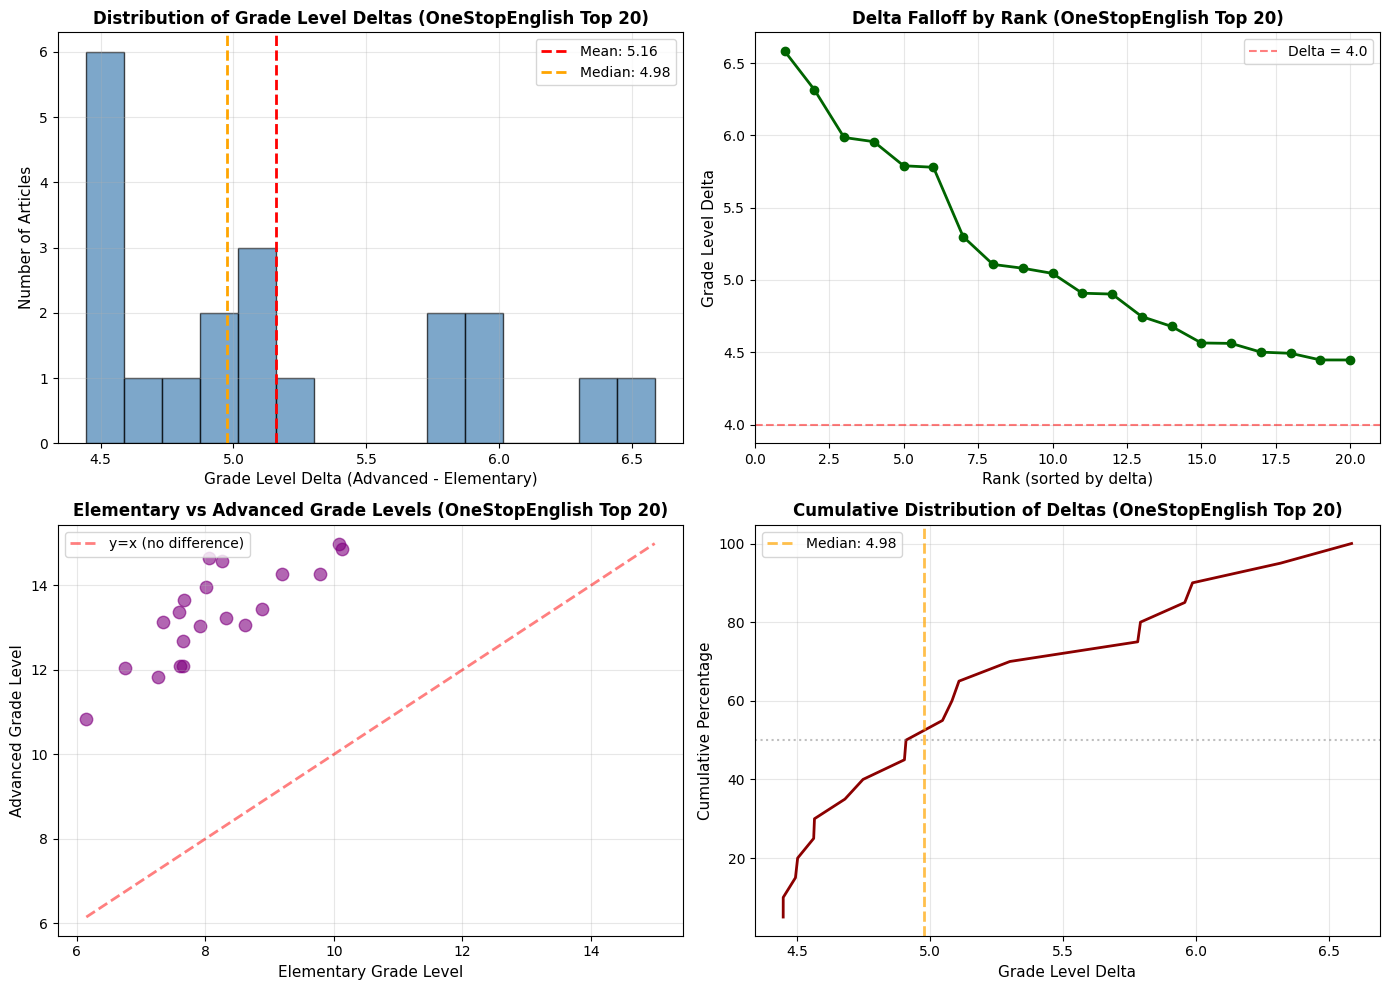


DATASET QUALITY ANALYSIS (TOP 20)

Total articles in full dataset: 189
Analyzing top 20 pairs for comparison with Wikipedia

Delta statistics (top 20):
  Mean:   5.160
  Median: 4.977
  Std:    0.675
  Min:    4.447
  Max:    6.584

Absolute grade levels:
  Elementary - Mean: 8.14, Range: [6.15, 10.12]
  Advanced   - Mean: 13.30, Range: [10.83, 14.99]

Top 20 delta range:
  Highest (rank 1):  6.584
  Rank 10:           5.046
  Lowest (rank 20):  4.447

Full dataset context:
  Pairs with delta > 4.0: 31
  Pairs with delta > 3.0: 82
  Pairs with delta > 2.0: 138

INTERPRETATION:
The top 20 pairs have deltas ranging from 4.45 to 6.58.
This represents a strong signal for the lowest-ranked
selected pair, and a strong signal for the top pair.

The mean delta of 5.16 (top 20) is substantially higher than
the full dataset mean of 2.86, confirming our selection strategy works well.


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Use only top 20 for apples-to-apples comparison with Wikipedia
df_top20 = df.head(20)

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of deltas
ax1 = axes[0, 0]
ax1.hist(df_top20['delta_gl'], bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(df_top20['delta_gl'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_top20["delta_gl"].mean():.2f}')
ax1.axvline(df_top20['delta_gl'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_top20["delta_gl"].median():.2f}')
ax1.set_xlabel('Grade Level Delta (Advanced - Elementary)', fontsize=11)
ax1.set_ylabel('Number of Articles', fontsize=11)
ax1.set_title('Distribution of Grade Level Deltas (OneStopEnglish Top 20)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta falloff (rank plot)
ax2 = axes[0, 1]
sorted_deltas = df_top20.sort_values('delta_gl', ascending=False)['delta_gl'].values
ranks = np.arange(1, len(sorted_deltas) + 1)
ax2.plot(ranks, sorted_deltas, 'o-', color='darkgreen', markersize=6, linewidth=2)
ax2.axhline(4.0, color='red', linestyle='--', alpha=0.5, label='Delta = 4.0')
ax2.set_xlabel('Rank (sorted by delta)', fontsize=11)
ax2.set_ylabel('Grade Level Delta', fontsize=11)
ax2.set_title('Delta Falloff by Rank (OneStopEnglish Top 20)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, len(sorted_deltas) + 1)

# 3. Elementary vs Advanced scatter
ax3 = axes[1, 0]
ax3.scatter(df_top20['elementary_gl'], df_top20['advanced_gl'], alpha=0.6, s=80, color='purple')
# Add diagonal line (y=x)
min_gl = min(df_top20['elementary_gl'].min(), df_top20['advanced_gl'].min())
max_gl = max(df_top20['elementary_gl'].max(), df_top20['advanced_gl'].max())
ax3.plot([min_gl, max_gl], [min_gl, max_gl], 'r--', linewidth=2, alpha=0.5, label='y=x (no difference)')
ax3.set_xlabel('Elementary Grade Level', fontsize=11)
ax3.set_ylabel('Advanced Grade Level', fontsize=11)
ax3.set_title('Elementary vs Advanced Grade Levels (OneStopEnglish Top 20)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution
ax4 = axes[1, 1]
sorted_deltas_asc = np.sort(df_top20['delta_gl'].values)
cumulative = np.arange(1, len(sorted_deltas_asc) + 1) / len(sorted_deltas_asc) * 100
ax4.plot(sorted_deltas_asc, cumulative, linewidth=2, color='darkred')
ax4.axvline(df_top20['delta_gl'].median(), color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {df_top20["delta_gl"].median():.2f}')
ax4.axhline(50, color='gray', linestyle=':', alpha=0.5)
ax4.set_xlabel('Grade Level Delta', fontsize=11)
ax4.set_ylabel('Cumulative Percentage', fontsize=11)
ax4.set_title('Cumulative Distribution of Deltas (OneStopEnglish Top 20)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some useful statistics
print("\n" + "="*60)
print("DATASET QUALITY ANALYSIS (TOP 20)")
print("="*60)
print(f"\nTotal articles in full dataset: {len(df)}")
print(f"Analyzing top 20 pairs for comparison with Wikipedia")
print(f"\nDelta statistics (top 20):")
print(f"  Mean:   {df_top20['delta_gl'].mean():.3f}")
print(f"  Median: {df_top20['delta_gl'].median():.3f}")
print(f"  Std:    {df_top20['delta_gl'].std():.3f}")
print(f"  Min:    {df_top20['delta_gl'].min():.3f}")
print(f"  Max:    {df_top20['delta_gl'].max():.3f}")

print(f"\nAbsolute grade levels:")
print(f"  Elementary - Mean: {df_top20['elementary_gl'].mean():.2f}, Range: [{df_top20['elementary_gl'].min():.2f}, {df_top20['elementary_gl'].max():.2f}]")
print(f"  Advanced   - Mean: {df_top20['advanced_gl'].mean():.2f}, Range: [{df_top20['advanced_gl'].min():.2f}, {df_top20['advanced_gl'].max():.2f}]")

print(f"\nTop 20 delta range:")
print(f"  Highest (rank 1):  {sorted_deltas[0]:.3f}")
print(f"  Rank 10:           {sorted_deltas[9]:.3f}")
print(f"  Lowest (rank 20):  {sorted_deltas[19]:.3f}")

print(f"\nFull dataset context:")
print(f"  Pairs with delta > 4.0: {len(df[df['delta_gl'] > 4.0])}")
print(f"  Pairs with delta > 3.0: {len(df[df['delta_gl'] > 3.0])}")
print(f"  Pairs with delta > 2.0: {len(df[df['delta_gl'] > 2.0])}")

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
print(f"The top 20 pairs have deltas ranging from {sorted_deltas[19]:.2f} to {sorted_deltas[0]:.2f}.")
print(f"This represents a {'strong' if sorted_deltas[19] > 4.0 else 'moderate' if sorted_deltas[19] > 3.0 else 'weak'} signal for the lowest-ranked")
print(f"selected pair, and a {'strong' if sorted_deltas[0] > 5.0 else 'moderate'} signal for the top pair.")
print(f"\nThe mean delta of {df_top20['delta_gl'].mean():.2f} (top 20) is substantially higher than")
print(f"the full dataset mean of {df['delta_gl'].mean():.2f}, confirming our selection strategy works well.")

## Complexity: English Wikipedia vs. Simple English Wikipedia

Our method here is to fetch from the English Wikipedia the titles of the [1,002 (as of this writing) level-three vital articles](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/3). This list, which is returned alphabetically by the API, we then shuffle with a fixed random seed (see `azimuth/config.py`). We then iterate over the shuffled list looking for Simple English Wikipedia articles with the same titles. When a candidate pair is found, we fetch both texts and compute corresponding Flesch-Kincaid grade levels. If the delta is less than 4.0, the pair is excluded. The first 20 contrasting pairs we find with grade level deltas higher than 4.0 are included in the dataset.

In [12]:
import requests
import time
import random
import sys
sys.path.append('..')
from azimuth.config import RANDOM_SEED, MIN_GRADE_LEVEL_DELTA, MIN_ARTICLE_LENGTH_REGULAR, MIN_ARTICLE_LENGTH_SIMPLE

# Set a proper User-Agent to comply with Wikipedia's API policy
HEADERS = {
    'User-Agent': 'AzimuthResearchProject/0.1 (Research) Python/requests'
}

# Check if we already have the data
data_dir = '../data'
wiki_all_pairs_path = os.path.join(data_dir, 'wikipedia_all_pairs.csv')

if os.path.exists(wiki_all_pairs_path):
    print("✓ Found existing Wikipedia data, loading from disk...")
    df_wiki = pd.read_csv(wiki_all_pairs_path)
    print(f"✓ Loaded {len(df_wiki)} pairs from {wiki_all_pairs_path}")
else:
    print("No existing data found, fetching from Wikipedia API...")
    
    def get_vital_articles_level3():
        """
        Fetch ALL Wikipedia Level 3 Vital Articles (~1000 fundamental topics).
        Handles pagination to get the complete list.
        """
        url = "https://en.wikipedia.org/w/api.php"
        all_articles = []
        plcontinue = None

        while True:
            params = {
                'action': 'query',
                'format': 'json',
                'titles': 'Wikipedia:Vital articles/Level/3',
                'prop': 'links',
                'pllimit': 'max',  # 500 per request
                'plnamespace': 0,  # Main namespace only
            }

            if plcontinue:
                params['plcontinue'] = plcontinue

            try:
                response = requests.get(url, params=params, headers=HEADERS, timeout=10)
                data = response.json()

                if 'query' in data and 'pages' in data['query']:
                    page = list(data['query']['pages'].values())[0]
                    if 'links' in page:
                        all_articles.extend([link['title'] for link in page['links']])

                    # Check if there are more results
                    if 'continue' in data and 'plcontinue' in data['continue']:
                        plcontinue = data['continue']['plcontinue']
                    else:
                        break
                else:
                    break
            except Exception as e:
                print(f"Error fetching vital articles: {e}")
                break

        return all_articles

    def check_simple_wikipedia(title):
        """Check if a Simple Wikipedia equivalent exists."""
        url = "https://simple.wikipedia.org/w/api.php"
        params = {
            'action': 'query',
            'format': 'json',
            'titles': title,
        }

        try:
            response = requests.get(url, params=params, headers=HEADERS, timeout=10)
            data = response.json()
            pages = data['query']['pages']
            page_id = list(pages.keys())[0]

            return None if page_id == '-1' else title
        except:
            return None

    def get_wikipedia_text(title, lang='en'):
        """Fetch article text from Wikipedia API."""
        url = f"https://{lang}.wikipedia.org/w/api.php"
        params = {
            'action': 'query',
            'format': 'json',
            'titles': title,
            'prop': 'extracts',
            'explaintext': True,
            'exsectionformat': 'plain',
        }

        try:
            response = requests.get(url, params=params, headers=HEADERS, timeout=10)
            data = response.json()
            pages = data['query']['pages']
            page = list(pages.values())[0]

            return page.get('extract', None)
        except Exception as e:
            print(f"Error fetching {title}: {e}")
            return None

    # Fetch ALL Wikipedia Level 3 Vital Articles
    print("Fetching Wikipedia Level 3 Vital Articles (may take 2-3 API calls)...")
    vital_articles = get_vital_articles_level3()
    print(f"✓ Found {len(vital_articles)} vital articles total")

    # Shuffle with fixed seed for reproducible random sampling
    print(f"Shuffling articles (random seed={RANDOM_SEED} for reproducibility)...")
    random.seed(RANDOM_SEED)
    random.shuffle(vital_articles)
    print(f"✓ Shuffled")

    print(f"\nSearching for articles with Simple Wikipedia equivalents and delta >= {MIN_GRADE_LEVEL_DELTA}...")
    print("(This may take a few minutes...)\n")

    wiki_pairs = []

    for i, title in enumerate(vital_articles):
        if len(wiki_pairs) >= 20:
            break

        # Check if Simple equivalent exists
        simple_title = check_simple_wikipedia(title)
        if not simple_title:
            continue

        # Fetch both texts
        print(f"[{i+1}/{len(vital_articles)}] {title}...", end=" ")

        regular_text = get_wikipedia_text(title, lang='en')
        simple_text = get_wikipedia_text(simple_title, lang='simple')

        if not regular_text or not simple_text:
            print("✗ (missing text)")
            continue

        # Filter very short articles
        if len(regular_text) < MIN_ARTICLE_LENGTH_REGULAR or len(simple_text) < MIN_ARTICLE_LENGTH_SIMPLE:
            print("✗ (too short)")
            continue

        # Compute grade levels
        try:
            regular_gl = textstat.flesch_kincaid_grade(regular_text)
            simple_gl = textstat.flesch_kincaid_grade(simple_text)
            delta = regular_gl - simple_gl

            if delta >= MIN_GRADE_LEVEL_DELTA:
                wiki_pairs.append({
                    'title': title,
                    'simple_text': simple_text,
                    'regular_text': regular_text,
                    'simple_gl': simple_gl,
                    'regular_gl': regular_gl,
                    'delta_gl': delta,
                    'simple_words': textstat.lexicon_count(simple_text, removepunct=True),
                    'regular_words': textstat.lexicon_count(regular_text, removepunct=True),
                })
                print(f"✓ (Δ={delta:.2f}) [{len(wiki_pairs)}/20]")
            else:
                print(f"✗ (Δ={delta:.2f}, below {MIN_GRADE_LEVEL_DELTA})")
        except Exception as e:
            print(f"✗ (error: {e})")
            continue

        # Be polite to Wikipedia's servers
        time.sleep(0.5)

    print(f"\n{'='*60}")
    print(f"WIKIPEDIA PAIR COLLECTION COMPLETE")
    print(f"{'='*60}")
    print(f"Found {len(wiki_pairs)} pairs with delta >= {MIN_GRADE_LEVEL_DELTA}")

    if len(wiki_pairs) > 0:
        df_wiki = pd.DataFrame(wiki_pairs)
        df_wiki = df_wiki.sort_values('delta_gl', ascending=False).reset_index(drop=True)

        # Save results
        os.makedirs(data_dir, exist_ok=True)
        df_wiki.to_csv(wiki_all_pairs_path, index=False)
        print(f"\n✓ Saved {len(df_wiki)} pairs to {wiki_all_pairs_path}")
    else:
        print("\n⚠ No pairs found! Try adjusting MIN_GRADE_LEVEL_DELTA in azimuth/config.py.")

# Always show summary statistics and save top 20
if len(df_wiki) > 0:
    print(f"\nGrade level delta statistics:")
    print(df_wiki['delta_gl'].describe())

    print(f"\nTop pairs:")
    print(df_wiki[['title', 'simple_gl', 'regular_gl', 'delta_gl', 'simple_words', 'regular_words']].head(20))

    # Save top 20 (or however many we got)
    top_wiki = df_wiki.head(20).copy()
    top_wiki_path = os.path.join(data_dir, 'wikipedia_top20_pairs.csv')
    top_wiki.to_csv(top_wiki_path, index=False)
    print(f"\n✓ Saved top {len(top_wiki)} pairs to {top_wiki_path}")

    # Save texts in extraction format
    wiki_texts = []
    for _, row in top_wiki.iterrows():
        wiki_texts.append({
            'title': row['title'],
            'low_complexity': row['simple_text'],
            'high_complexity': row['regular_text'],
        })

    wiki_texts_path = os.path.join(data_dir, 'wikipedia_top20_texts.json')
    with open(wiki_texts_path, 'w') as f:
        json.dump(wiki_texts, f, indent=2)

    print(f"✓ Saved texts to {wiki_texts_path}")
    print(f"\nReady for vector extraction!")

✓ Found existing Wikipedia data, loading from disk...
✓ Loaded 20 pairs from ../data/wikipedia_all_pairs.csv

Grade level delta statistics:
count    20.000000
mean      5.384192
std       1.109559
min       4.219071
25%       4.530686
50%       5.034045
75%       5.779365
max       8.002375
Name: delta_gl, dtype: float64

Top pairs:
                title  simple_gl  regular_gl  delta_gl  simple_words  \
0            Military   8.471316   16.473691  8.002375           924   
1              Reason   8.453117   15.616480  7.163363           110   
2         Ibn Khaldun   7.046655   14.157208  7.110553           183   
3     Political party  10.706652   17.546623  6.839971           538   
4   Leonardo da Vinci   7.533377   13.808560  6.275183          4498   
5    Great Depression   6.981062   12.595154  5.614093           591   
6               Clock   6.169327   11.610497  5.441170           860   
7               Color   7.984217   13.320431  5.336213           184   
8              Ox

### Dataset Quality Analysis: Wikipedia

How does Wikipedia compare to OneStopEnglish in signal quality?

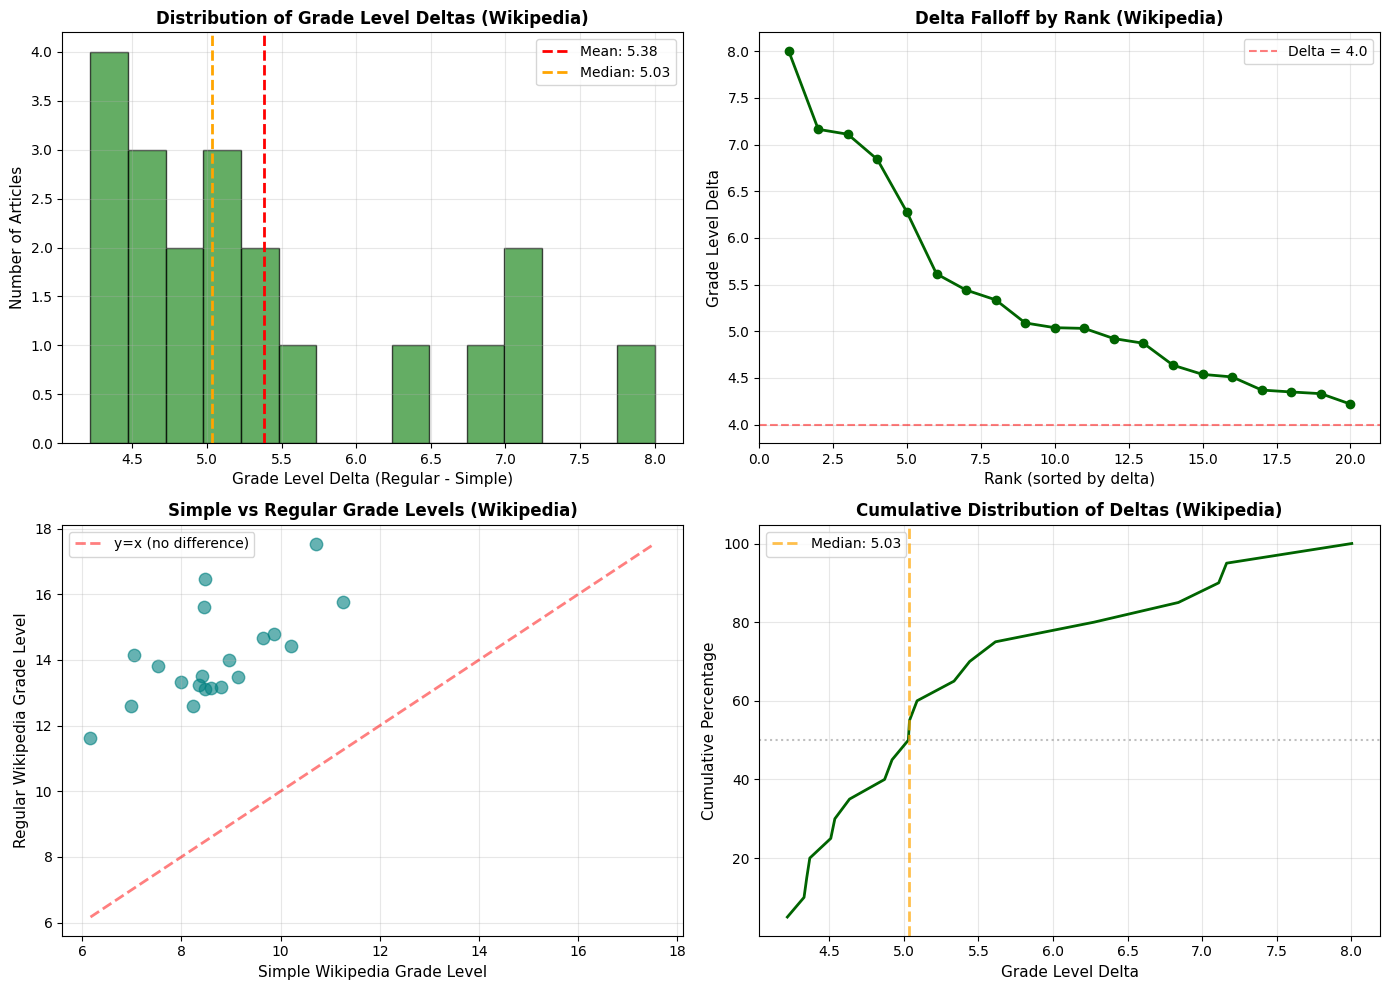


WIKIPEDIA DATASET QUALITY ANALYSIS

Total articles: 20

Delta statistics:
  Mean:   5.384
  Median: 5.034
  Std:    1.110
  Min:    4.219
  Max:    8.002

Absolute grade levels:
  Simple  - Mean: 8.67, Range: [6.17, 11.27]
  Regular - Mean: 14.05, Range: [11.61, 17.55]

Delta range:
  Highest (rank 1):  8.002
  Rank 10:           5.038
  Lowest (rank 20):  4.219

COMPARISON WITH ONESTOP

OneStopEnglish top-20 delta range: 4.45 to 6.58
Wikipedia delta range:              4.22 to 8.00

OneStopEnglish mean delta (top 20): 5.16
Wikipedia mean delta:                5.38

Difference in mean signal strength: +0.22 grade levels

INTERPRETATION:
Wikipedia shows COMPARABLE signal compared to OneStopEnglish.

Wikipedia deltas range from 4.22 to 8.00,
vs OneStopEnglish's 4.45 to 6.58.

Both datasets provide good signal quality (all pairs above 4.0 threshold).


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Load OneStopEnglish data for comparison (in case this cell runs independently)
if 'df' not in locals():
    df = pd.read_csv('../data/onestop_all_pairs.csv')

# Create a figure with multiple subplots (same layout as OneStopEnglish analysis)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of deltas
ax1 = axes[0, 0]
ax1.hist(df_wiki['delta_gl'], bins=15, color='forestgreen', alpha=0.7, edgecolor='black')
ax1.axvline(df_wiki['delta_gl'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_wiki["delta_gl"].mean():.2f}')
ax1.axvline(df_wiki['delta_gl'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_wiki["delta_gl"].median():.2f}')
ax1.set_xlabel('Grade Level Delta (Regular - Simple)', fontsize=11)
ax1.set_ylabel('Number of Articles', fontsize=11)
ax1.set_title('Distribution of Grade Level Deltas (Wikipedia)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta falloff (rank plot)
ax2 = axes[0, 1]
sorted_deltas_wiki = df_wiki.sort_values('delta_gl', ascending=False)['delta_gl'].values
ranks_wiki = np.arange(1, len(sorted_deltas_wiki) + 1)
ax2.plot(ranks_wiki, sorted_deltas_wiki, 'o-', color='darkgreen', markersize=6, linewidth=2)
ax2.axhline(4.0, color='red', linestyle='--', alpha=0.5, label='Delta = 4.0')
ax2.set_xlabel('Rank (sorted by delta)', fontsize=11)
ax2.set_ylabel('Grade Level Delta', fontsize=11)
ax2.set_title('Delta Falloff by Rank (Wikipedia)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, len(sorted_deltas_wiki) + 1)

# 3. Simple vs Regular scatter
ax3 = axes[1, 0]
ax3.scatter(df_wiki['simple_gl'], df_wiki['regular_gl'], alpha=0.6, s=80, color='teal')
# Add diagonal line (y=x)
min_gl_wiki = min(df_wiki['simple_gl'].min(), df_wiki['regular_gl'].min())
max_gl_wiki = max(df_wiki['simple_gl'].max(), df_wiki['regular_gl'].max())
ax3.plot([min_gl_wiki, max_gl_wiki], [min_gl_wiki, max_gl_wiki], 'r--', linewidth=2, alpha=0.5, label='y=x (no difference)')
ax3.set_xlabel('Simple Wikipedia Grade Level', fontsize=11)
ax3.set_ylabel('Regular Wikipedia Grade Level', fontsize=11)
ax3.set_title('Simple vs Regular Grade Levels (Wikipedia)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution
ax4 = axes[1, 1]
sorted_deltas_wiki_asc = np.sort(df_wiki['delta_gl'].values)
cumulative_wiki = np.arange(1, len(sorted_deltas_wiki_asc) + 1) / len(sorted_deltas_wiki_asc) * 100
ax4.plot(sorted_deltas_wiki_asc, cumulative_wiki, linewidth=2, color='darkgreen')
ax4.axvline(df_wiki['delta_gl'].median(), color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {df_wiki["delta_gl"].median():.2f}')
ax4.axhline(50, color='gray', linestyle=':', alpha=0.5)
ax4.set_xlabel('Grade Level Delta', fontsize=11)
ax4.set_ylabel('Cumulative Percentage', fontsize=11)
ax4.set_title('Cumulative Distribution of Deltas (Wikipedia)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*60)
print("WIKIPEDIA DATASET QUALITY ANALYSIS")
print("="*60)
print(f"\nTotal articles: {len(df_wiki)}")
print(f"\nDelta statistics:")
print(f"  Mean:   {df_wiki['delta_gl'].mean():.3f}")
print(f"  Median: {df_wiki['delta_gl'].median():.3f}")
print(f"  Std:    {df_wiki['delta_gl'].std():.3f}")
print(f"  Min:    {df_wiki['delta_gl'].min():.3f}")
print(f"  Max:    {df_wiki['delta_gl'].max():.3f}")

print(f"\nAbsolute grade levels:")
print(f"  Simple  - Mean: {df_wiki['simple_gl'].mean():.2f}, Range: [{df_wiki['simple_gl'].min():.2f}, {df_wiki['simple_gl'].max():.2f}]")
print(f"  Regular - Mean: {df_wiki['regular_gl'].mean():.2f}, Range: [{df_wiki['regular_gl'].min():.2f}, {df_wiki['regular_gl'].max():.2f}]")

print(f"\nDelta range:")
print(f"  Highest (rank 1):  {sorted_deltas_wiki[0]:.3f}")
if len(sorted_deltas_wiki) >= 10:
    print(f"  Rank 10:           {sorted_deltas_wiki[9]:.3f}")
print(f"  Lowest (rank {len(sorted_deltas_wiki)}):  {sorted_deltas_wiki[-1]:.3f}")

print("\n" + "="*60)
print("COMPARISON WITH ONESTOP")
print("="*60)

# Get OneStopEnglish top-20 for comparison
df_top20 = df.head(20)
sorted_deltas = df_top20.sort_values('delta_gl', ascending=False)['delta_gl'].values

print(f"\nOneStopEnglish top-20 delta range: {sorted_deltas[19]:.2f} to {sorted_deltas[0]:.2f}")
print(f"Wikipedia delta range:              {sorted_deltas_wiki[-1]:.2f} to {sorted_deltas_wiki[0]:.2f}")
print(f"\nOneStopEnglish mean delta (top 20): {df_top20['delta_gl'].mean():.2f}")
print(f"Wikipedia mean delta:                {df_wiki['delta_gl'].mean():.2f}")
print(f"\nDifference in mean signal strength: {df_wiki['delta_gl'].mean() - df_top20['delta_gl'].mean():+.2f} grade levels")

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)

wiki_mean = df_wiki['delta_gl'].mean()
onestop_mean = df_top20['delta_gl'].mean()

if wiki_mean > onestop_mean + 0.5:
    strength = "STRONGER"
elif wiki_mean < onestop_mean - 0.5:
    strength = "WEAKER"
else:
    strength = "COMPARABLE"

print(f"Wikipedia shows {strength} signal compared to OneStopEnglish.")
print(f"\nWikipedia deltas range from {sorted_deltas_wiki[-1]:.2f} to {sorted_deltas_wiki[0]:.2f},")
print(f"vs OneStopEnglish's {sorted_deltas[19]:.2f} to {sorted_deltas[0]:.2f}.")
print(f"\nBoth datasets provide {'good' if min(sorted_deltas_wiki[-1], sorted_deltas[19]) > 4.0 else 'adequate'} signal quality (all pairs above {MIN_GRADE_LEVEL_DELTA} threshold).")